# Resposta às perguntas do arquivo "perguntas_api.md"

**Tema: Integração com APIs - Feriados e Tempo**

### APIs públicas a serem utilizadas:
- [Public Holiday API](https://date.nager.at/Api)
- [Open-Meteo Historical Weather API](https://open-meteo.com/)

In [222]:
# Libs necessárias
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import locale

# Configurar localidade para português do Brasil
locale.setlocale(locale.LC_TIME, "Portuguese_Brazil.1252")

# Função para pegar dados do tempo
def pegar_dados_tempo(local: str, data_inicial: str, data_final: str, daily_vars):
    """
    Retorna um objeto pd.DataFrame com os dados diários de tempo para um local entre duas datas estabelecidas. Os dados são coletados do Open-Meteo Historical Weather API. Para mais informações, acesse: <https://open-meteo.com/>
    
    Args:
        local (str): Nome da cidade ou localidade (ex: 'Rio de Janeiro')
        start_date (str): Data de início no formato 'YYYY-MM-DD'
        end_date (str): Data de fim no formato 'YYYY-MM-DD'
        daily_vars (str ou list): Variáveis desejadas (ex: 'temperature_2m_mean ou ['temperature_2m_mean', 'weather_code'])
    
    Retorna:
        df (pd.DataFrame): um DataFrame com colunas de dados climáticos
    """
    
    # Verificar se é string para converter para lista
    if isinstance(daily_vars, str):
        daily_vars = [daily_vars]
    
    # API para fazer o geocoding
    url_geocode = 'https://geocoding-api.open-meteo.com/v1/search'
    params_geocode = {
        'name': local,
        'count': 1
    }
    resp_geocode = requests.get(url=url_geocode, params=params_geocode)
    resp_geocode.raise_for_status()
    dict_geocode = resp_geocode.json()['results'][0]
    
    # API dos dados de tempo
    url_weather = "https://archive-api.open-meteo.com/v1/archive"
    params_weather = {
        'latitude': dict_geocode['latitude'],
        'longitude': dict_geocode['longitude'],
        'start_date': data_inicial,
        'end_date': data_final,
        'daily': daily_vars,
        'timezone': 'America/Sao_Paulo'
    }
    
    # Acessando os dados
    resp_weather = requests.get(url=url_weather, params=params_weather)
    resp_weather.raise_for_status()
    dados = resp_weather.json()['daily']

    # Convertendo para DataFrame
    df = pd.DataFrame(dados)
    df['time'] = pd.to_datetime(df['time'])
    
    return df

def pegar_desc_wmo_code():
    """
    Retorna um objeto pd.DataFrame contendo as descrições para dia e noite dos códigos weather_code do Open-Meteo Historical Weather API.
    
    Retorna:
        df_wmo (pd.DataFrame): tabela com três colunas: codigo weather_code, descrição do código durante o dia e durante a noite.
    """
    
    url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/descriptions.json'
    
    resp = requests.get(url)
    resp.raise_for_status()
    
    # Converte para json
    dict = resp.json()
    
    dict_final = [
    {
        'weather_code': int(code),
        'desc_day': dict[code]['day']['description'],
        'desc_night': dict[code]['night']['description']
    }
    for code in dict
    ]
       
    df_wmo = pd.DataFrame(dict_final)
    
    return df_wmo

def aplicar_nome_mes(df: pd.DataFrame, coluna_data: str):
    """
    Retorna um df com uma nova coluna chamada 'nome_mes' que contém o nome do mês. A coluna é uma categoria, ou seja, seguirá a ordem dos meses em um ano.
    
    Args:
        df (pd.DataFrame): um data frame que contenha uma coluna em formato datetime.
        coluna_data (str): nome da coluna que contém as datas.
        
    Retorna:
        df (pd.DataFrame): um novo data frame com uma coluna com o nome do mês.
    """
    
    df['nome_mes'] = df[coluna_data].dt.month_name(locale='Portuguese_Brazil.1252')
    
    ordem_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
               'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
    
    df['nome_mes'] = pd.Categorical(df['nome_mes'],
                                    categories=ordem_meses,
                                    ordered=True)
    
    return df

def traduzir_wmo_code(df: pd.DataFrame, coluna_wmo: str, nome_desc: str = 'desc_wmo_pt'):
    """
    Traduz os códigos WMO, da coluna `weather_code` para o português. Apenas os códigos que apareceram na base coletada df_tempo foram contemplados
    
    Args:
        df (pd.DataFrame): data frame que possui uma coluna com os códigos wmo
        coluna_wmo (str): nome da coluna que possui códigos wmo
        nome_desc (str): nome da coluna que descreverá os códigos wmo. O padrão é 'desc_wmo_pt'
        
    retorna
        df (pd.DataFrame): data frame com uma nova coluna com a descrição em português dos códigos WMO
    """
    
    dict_desc = {
        0: 'Ensolarado',
        1: 'Principalmente ensolarado',
        2: 'Parcialmente nublado',
        3: 'Nublado',
        51: 'Garoa leve',
        53: 'Garoa moderada',
        55: 'Garoa forte',
        61: 'Chuva leve',
        63: 'Chuva moderada',
        65: 'Chuva forte'
    }
    
    df[nome_desc] = df[coluna_wmo].map(dict_desc)
    
    return df

In [223]:
# Dados de feriado

# Parâmetros
year = '2024'
country = 'BR'

# url
feriado_api_url = f'https://date.nager.at/api/v3/publicholidays/{year}/{country}'

# Requisição
resp_feriado = requests.get(feriado_api_url)

# Só converte se o status for 200
if resp_feriado.status_code == 200:
    feriado = resp_feriado.json()
    df_feriado = pd.DataFrame(feriado)
    
    df_feriado = df_feriado.loc[:, ['date', 'localName']]
    df_feriado['date'] = pd.to_datetime(df_feriado['date'])
    df_feriado = aplicar_nome_mes(df_feriado, 'date')
    print(df_feriado)
else:
    print("A requisição falhou.")

         date                             localName   nome_mes
0  2024-01-01            Confraternização Universal    Janeiro
1  2024-02-12                              Carnaval  Fevereiro
2  2024-02-13                              Carnaval  Fevereiro
3  2024-03-29                     Sexta-feira Santa      Março
4  2024-03-31                     Domingo de Páscoa      Março
5  2024-04-21                     Dia de Tiradentes      Abril
6  2024-05-01                    Dia do Trabalhador       Maio
7  2024-05-30                        Corpus Christi       Maio
8  2024-07-09  Revolução Constitucionalista de 1932      Julho
9  2024-09-07                  Dia da Independência   Setembro
10 2024-10-12               Nossa Senhora Aparecida    Outubro
11 2024-11-02                        Dia de Finados   Novembro
12 2024-11-15              Proclamação da República   Novembro
13 2024-11-20              Dia da Consciência Negra   Novembro
14 2024-12-25                                 Natal   D

In [224]:
# Dados de tempo

df_tempo = pegar_dados_tempo(local = 'Rio de Janeiro',
                             data_inicial = '2024-01-01',
                             data_final='2024-12-31',
                             daily_vars=['temperature_2m_mean', 'weather_code']
                             )

# Criando a coluna mês
df_tempo = aplicar_nome_mes(df_tempo, 'time')

### 1. Quantos feriados há no Brasil em todo o ano de 2024?

In [225]:
total_feriados = df_feriado['date'].count()

print(f'Total de feriados no Brasil em 2024: {total_feriados}')

Total de feriados no Brasil em 2024: 15


### 2. Qual mês de 2024 tem o maior número de feriados?

In [226]:
mes_mais_feriados = df_feriado['nome_mes'].value_counts().reset_index()

print(f'O mês com o maior número de feriados com o {mes_mais_feriados.iloc[0, 0]} com {mes_mais_feriados.iloc[0, 1]} feriados em 2024.')

O mês com o maior número de feriados com o Novembro com 3 feriados em 2024.


### 3. Quantos feriados em 2024 caem em dias de semana (segunda a sexta-feira)?

In [227]:
feriados_dias_semana = df_feriado.loc[df_feriado['date'].dt.day_of_week < 4, 'date'].count()
print(f'O ano de 2024 teve {feriados_dias_semana} feriados que caíram em dias da semana.')

O ano de 2024 teve 8 feriados que caíram em dias da semana.


### 4. Qual foi a temperatura média em cada mês?

A partir dos dados da Open-Meteo para o Rio de Janeiro, calculei a média mensal das temperaturas médias diárias.O gráfico abaixo mostra a variação ao longo dos meses. Por mais que sejam dados temporais, optei pelo gráfico de barras, visto que este é o padrão em climatologia para visualização de dados de temperatura.

Critérios:
- A média foi calculada a partir da coluna `temperature_2m_mean`;
- Os nomes dos meses estão formatados em português;
- Os dados foram agrupados por mês (ano + mês) para preservar a ordem temporal.

C:\Users\Paulo Vitor\AppData\Local\Temp\ipykernel_30924\1460264321.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('nome_mes')


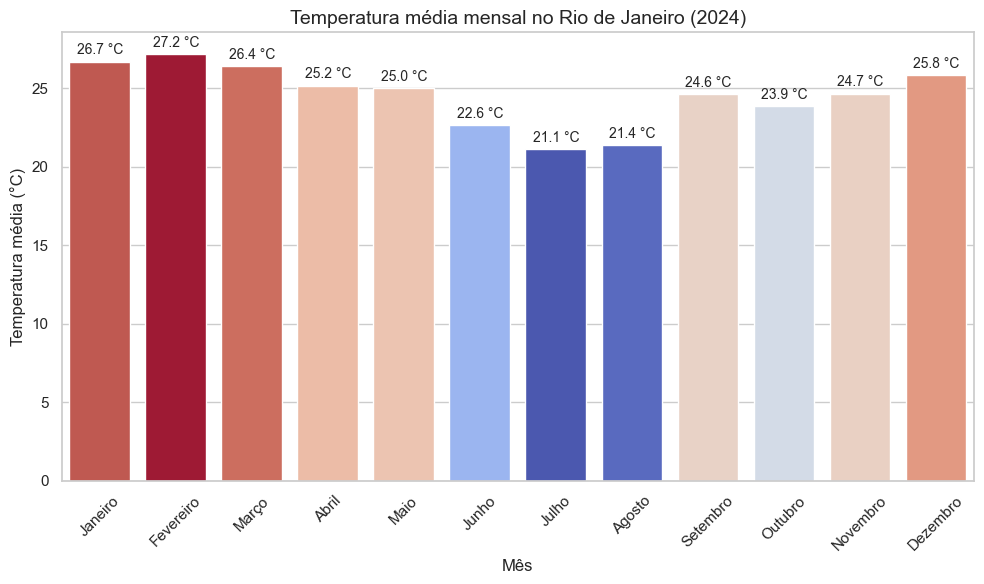

In [228]:

# Calculando as temperaturas médias dos meses de 2024
temp_media_mes = (
    df_tempo
    .groupby('nome_mes')
    .agg(media_mes = ('temperature_2m_mean', 'mean'))
    .round(2)
    .sort_values('nome_mes')
    .reset_index()
)

# Define o estilo do gráfico
sns.set_theme(style="whitegrid")

# Gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=temp_media_mes,
    x='nome_mes',
    y='media_mes',
    hue='media_mes',
    palette='coolwarm',
    legend=False
)

ax.set_title('Temperatura média mensal no Rio de Janeiro (2024)', fontsize=14)
ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Temperatura média (°C)', fontsize=12)
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f °C', fontsize=10, label_type='edge', padding=3)
plt.tight_layout()
plt.show()


In [229]:
# Em formato de tabela
temp_media_mes.head(12)

,nome_mes,media_mes
0,Janeiro,26.70
1,Fevereiro,27.20
2,Março,26.42
3,Abril,25.17
4,Maio,24.99
5,Junho,22.64
6,Julho,21.11
7,Agosto,21.39
8,Setembro,24.61
9,Outubro,23.86


### 5. Qual foi o tempo predominante em cada mês nesse período ?

In [230]:
tempo_predominante = (
    df_tempo.groupby('nome_mes', observed=True)
    .agg(weather_code = ('weather_code', pd.Series.mode))
    .reset_index()
    .sort_values('nome_mes')
    .merge(df_wmo, on='weather_code', how='left')
)

tempo_predominante = traduzir_wmo_code(tempo_predominante, 'weather_code', 'desc_wmo_pt')

print('Tempo predominante para cada mês:')
for i in range(len(tempo_predominante)):
    print(f'{tempo_predominante.iloc[i, 0]}: {tempo_predominante.iloc[i, -1]}')

Tempo predominante para cada mês:
Janeiro: Chuva moderada
Fevereiro: Garoa leve
Março: Garoa leve
Abril: Nublado
Maio: Garoa leve
Junho: Nublado
Julho: Nublado
Agosto: Ensolarado
Setembro: Nublado
Outubro: Nublado
Novembro: Garoa leve
Dezembro: Garoa leve


### 6. Qual foi o tempo e a temperatura média em cada feriado de 01/01/2024 a 01/08/2024?

In [231]:
tempo_feriados_ate_agosto = (
    df_feriado.loc[df_feriado['date'] <= '2024-08-01', :]
    .merge(df_tempo, left_on='date', right_on='time', how='left')
)

tempo_feriados_ate_agosto = (
    traduzir_wmo_code(tempo_feriados_ate_agosto, 'weather_code', 'desc_wmo_pt')
    .loc[:, ['date', 'localName', 'temperature_2m_mean', 'desc_wmo_pt']]
    .assign(
        date_str = lambda x: x.date.dt.strftime('%d de %B de %Y')
    )
)

print('Tempo e Temperatura média para os feriados que ocorreram entre 01/01/2024 e 01/08/2024:')

for i in range(len(tempo_feriados_ate_agosto)):
    print(f'Feriado de {tempo_feriados_ate_agosto.iloc[i,1]} ({tempo_feriados_ate_agosto.iloc[i, -1]}): {tempo_feriados_ate_agosto.iloc[i, -2]} com temperatura média de {tempo_feriados_ate_agosto.iloc[i, 2]}°C.')

Tempo e Temperatura média para os feriados que ocorreram entre 01/01/2024 e 01/08/2024:
Feriado de Confraternização Universal (01 de janeiro de 2024): Garoa leve com temperatura média de 24.9°C.
Feriado de Carnaval (12 de fevereiro de 2024): Nublado com temperatura média de 30.2°C.
Feriado de Carnaval (13 de fevereiro de 2024): Garoa leve com temperatura média de 30.5°C.
Feriado de Sexta-feira Santa (29 de março de 2024): Chuva leve com temperatura média de 25.0°C.
Feriado de Domingo de Páscoa (31 de março de 2024): Garoa moderada com temperatura média de 24.5°C.
Feriado de Dia de Tiradentes (21 de abril de 2024): Parcialmente nublado com temperatura média de 23.1°C.
Feriado de Dia do Trabalhador (01 de maio de 2024): Ensolarado com temperatura média de 28.1°C.
Feriado de Corpus Christi (30 de maio de 2024): Garoa leve com temperatura média de 20.8°C.
Feriado de Revolução Constitucionalista de 1932 (09 de julho de 2024): Garoa moderada com temperatura média de 21.5°C.


### 7. Considerando as suposições dadas, houve algum feriado 'não aproveitável' em 2024? Se sim, qual(ais)?

In [232]:
tempo_feriados = (
    df_feriado.merge(df_tempo, left_on='date', right_on='time', how='left')
)

tempo_feriados = (
    traduzir_wmo_code(tempo_feriados, 'weather_code', 'desc_wmo_pt')
    .loc[:, ['date', 'localName', 'weather_code', 'temperature_2m_mean', 'desc_wmo_pt']]
    .assign(
        date_str = lambda x: x.date.dt.strftime('%d de %B de %Y')
    )
)

condicoes_praia = (tempo_feriados['temperature_2m_mean'] < 20) | ~(tempo_feriados['weather_code'].isin([0, 1, 2]))

feriados_n_aproveitados = tempo_feriados.loc[condicoes_praia]

qtd_feriados_n_aproveitados = feriados_n_aproveitados['date'].count()

print(f'Sim, houveram {qtd_feriados_n_aproveitados} feriados não aproveitáveis em 2024.\nSegue lista abaixo:\n')

for i in range(len(feriados_n_aproveitados)):
    print(f'Feriado de {feriados_n_aproveitados.iloc[i,1]} ({feriados_n_aproveitados.iloc[i, -1]}): {feriados_n_aproveitados.iloc[i, -2]} com temperatura média de {feriados_n_aproveitados.iloc[i, 3]}°C.')

Sim, houveram 13 feriados não aproveitáveis em 2024.
Segue lista abaixo:

Feriado de Confraternização Universal (01 de janeiro de 2024): Garoa leve com temperatura média de 24.9°C.
Feriado de Carnaval (12 de fevereiro de 2024): Nublado com temperatura média de 30.2°C.
Feriado de Carnaval (13 de fevereiro de 2024): Garoa leve com temperatura média de 30.5°C.
Feriado de Sexta-feira Santa (29 de março de 2024): Chuva leve com temperatura média de 25.0°C.
Feriado de Domingo de Páscoa (31 de março de 2024): Garoa moderada com temperatura média de 24.5°C.
Feriado de Corpus Christi (30 de maio de 2024): Garoa leve com temperatura média de 20.8°C.
Feriado de Revolução Constitucionalista de 1932 (09 de julho de 2024): Garoa moderada com temperatura média de 21.5°C.
Feriado de Dia da Independência (07 de setembro de 2024): Nublado com temperatura média de 24.3°C.
Feriado de Nossa Senhora Aparecida (12 de outubro de 2024): Chuva moderada com temperatura média de 26.1°C.
Feriado de Dia de Finados 

### 8. Qual foi o feriado 'mais aproveitável' de 2024?

In [233]:
condicao_melhor_praia = (tempo_feriados['temperature_2m_mean'] >= 20) & (tempo_feriados['weather_code'].isin([0, 1, 2]))

melhor_feriado_praia = tempo_feriados.loc[condicao_melhor_praia].sort_values('weather_code')

print(f'O melhor feriado para praia foi o {melhor_feriado_praia.iloc[0, 1]} que ocorreu no dia {melhor_feriado_praia.iloc[0, -1]}.')

O melhor feriado para praia foi o Dia do Trabalhador que ocorreu no dia 01 de maio de 2024.
